In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pvlib as pv
import CoolProp.CoolProp as CP
import warnings
from scipy import interpolate
from simulation_functions import corr_exp_solar, Irradiance_2,State
from bokeh.plotting.figure import Figure
from bokeh.plotting import figure, output_notebook, show
from bokeh.palettes import Dark2_5 as palette
# itertools handles the cycling
import itertools  

<Figure size 1000x600 with 2 Axes>

<Figure size 1000x600 with 1 Axes>

In [102]:

class Storage:
    
    def __init__(self,Storage_param):
        
        '''
        Storage's constructor function
        '''
        self.n_nodes=Storage_param['n_nodes']
        self.T_max=Storage_param['T_max']
        self.T_min=Storage_param['T_min']
        
        self.nodes_Temperature=np.linspace(self.T_max,self.T_min,self.n_nodes)
        
        self.h_nodes=Storage_param['H']/self.n_nodes
        self.P=Storage_param['P']*100000
        self.D=D
        self.H=H
        self.A_circ=np.pi*(self.D/2)**2
        self.A_cil_ext=np.pi*self.D*self.h_nodes
        
        self.k_storage=Storage_param['k_storage']
        self.e_storage=Storage_param['e_storage']
        self.k_insulation=Storage_param['k_insulation']
        self.e_insulation=Storage_param['e_insulation']
        
        self.nodes_height=np.linspace(0,self.H,self.n_nodes+1)
        
        self.h_in=Storage_param['h_in']
        self.h_out=Storage_param['h_out']

        self.M_in,self.M_out=self.M_vector()
        
    def M_vector(self):
        m_in=np.zeros([self.n_nodes,len(self.h_in)])
        m_out=np.zeros([self.n_nodes,len(self.h_out)])
        
        for i in range(len(self.h_in)):
            for j in range(self.n_nodes):
                if self.nodes_height[j]<=self.h_in[i]<self.nodes_height[j+1]:
                    m_in[j][i]=1
        
        for i in range(len(self.h_out)):
            for j in range(self.n_nodes):
                if self.nodes_height[j]<=self.h_out[i]<self.nodes_height[j+1]:
                    m_out[j][i]=-1
        
        return m_in,m_out
        #return np.flip(m_in,0),np.flip(m_out,0)
        
    def R_k_cil_external(self,k,D_ext,D_int):
        
        '''
        Method that calculates the conductive thermal resistance of a cylindrical shell
        
        Parameters:
        ----------- 
            -k    : Thermal conductivity of the cylindrical shell material, W/(m*K)
            -D_ext: External diameter of the cylindrical shell, m
            -D_int: Internal diameter of the cylindrical shell, m
            
        Outputs:
        -----------
            -R_k : Conductive thermal resistance ot the cylindrical shell, K/W
            
        '''
        L=self.h_nodes # Height of the cylindrical shell, m
        
        R_k=np.log(D_ext/D_int)/(2*np.pi*L*k) #Conductive thermal resistance ot the cylindrical shell, K/W
        return R_k
    
    def UA_top_bottom(self,T_inf,T_f):
        
        '''
        Function that calculates the 
        '''
        g=9.8
        L=self.h_nodes
        D=self.D
        
        T_s=(T_f+T_inf)/2
        
        it=0
        while True:    
            
            T_p=(T_inf+T_s)/2
            nu_air_ext=CP.PropsSI('V','P',self.P,'T',T_p+273,'air')/CP.PropsSI('D','P',self.P,'T',T_p+273,'air') 
            B_air_ext=1/(T_p+273) 
            Gr=g*B_air_ext*np.abs(T_s-T_inf)*(L**3)/(nu_air_ext**2)
            Pr_air_ext=CP.PropsSI('PRANDTL','P',self.P,'T',T_p+273,'air')
            Ra=Gr*Pr_air_ext

            if 0<Ra<10**9:#10**4<Ra<10**9:
                h=1.32*(np.abs(T_s-T_inf)/D)**0.25
            elif Ra>=10**9:
                h=1.43*np.abs(T_s-T_inf)**(1/3)
            else:
                h=0.001
                
            if self.k_storage!=0: 
                R_k_storage=self.e_storage/(self.k_storage*self.A_circ)
            else:
                R_k_storage=0
            
            if self.k_insulation!=0: 
                R_k_insulation=self.e_insulation/(self.k_insulation*self.A_circ)    
            else:
                R_k_insulation=0
                
            U_h_ext=(1/(h*self.A_cil_ext)+R_k_storage+R_k_insulation)**(-1)
                  
            Q_f_inf=(T_f-T_inf)*U_h_ext
            Q_s_inf=(T_s-T_inf)*self.A_circ*h
            
            err=np.abs(Q_f_inf-Q_s_inf)/Q_s_inf*100
            
            if err<=0.1 or it>=200:
                break
            
            else:
                T_s=T_inf+Q_f_inf/(self.A_circ*h)
                it+=1
                
        return U_h_ext
        
        
        
    def UA_external_surface(self,T_inf,T_f,g=9.8):
        
        g=9.8
        L=self.h_nodes
        D=self.D
        
        T_s=(T_f+T_inf)/2
        
        it=0

        while True:    
            
            T_p=(T_inf+T_s)/2
            nu_air_ext=CP.PropsSI('V','P',self.P,'T',T_p+273,'air')/CP.PropsSI('D','P',self.P,'T',T_p+273,'air')
            B_air_ext=1/(T_p+273)   
            Gr=g*B_air_ext*np.abs(T_s-T_inf)*(L**3)/(nu_air_ext**2)
            Pr_air_ext=CP.PropsSI('PRANDTL','P',self.P,'T',T_p+273,'air')
            Ra=Gr*Pr_air_ext

            if 10**4<Ra<10**9:#10**4<Ra<10**9:
                h=1.42*(np.abs(T_s-T_inf)/L)**0.25
            elif Ra>=10**9:
                h=0.95*np.abs(T_s-T_inf)**(1/3)
            else:
                h=0.001
               
            if self.k_storage!=0: 
                R_k_storage=self.R_k_cil_external(self.k_storage,D_ext=D,D_int=D-self.e_storage)    
            else:
                R_k_storage=0
            
            if self.k_insulation!=0: 
                R_k_insulation=self.R_k_cil_external(self.k_insulation,D_ext=D+self.e_insulation,D_int=D)    
            else:
                R_k_insulation=0
                    
            U_h_ext=(1/(h*self.A_cil_ext)+R_k_storage+R_k_insulation)**(-1)
            
            Q_f_inf=(T_f-T_inf)*U_h_ext
            Q_s_inf=(T_s-T_inf)*self.A_cil_ext*h
            
            err=np.abs((Q_f_inf-Q_s_inf)/Q_s_inf*100)
            if err<=0.1 or it>=200:
                break
            
            else:
                T_s=T_inf+Q_f_inf/(self.A_cil_ext*h)
                it+=1
                
        return U_h_ext
    
    def Conduction(self,T_hot,T_cold):
        
        k_nodes=CP.PropsSI('L','P',self.P,'T',np.linspace(273+np.max(self.nodes_Temperature),273+np.min(self.nodes_Temperature),n_nodes),'water')
        k_nodes=np.mean(k_nodes)
        
        Q_cond=k_nodes*self.A_circ*(T_hot-T_cold)/self.h_nodes
        
        return Q_cond
            
    def Energy_balance(self,dt,T_inf):
        '''
        Function that calculates and updates the temperature of each node by doing an energy balance.
        
        Parameters:
        -----------
        dt   : Time step of the simulation, s.
        T_inf: Ambient temperature, °C
        
        Outputs:
        ---------
        nodes.Temperature: Numpy array of shape (n_nodes,) that contains the resulting temperature of each node
        
        '''        
        
        cp_nodes=CP.PropsSI('C','P',self.P,'T',                               # Array that contains 
                            np.linspace(273+np.max(self.nodes_Temperature),   # the value of Cp on
                            273+np.min(self.nodes_Temperature),n_nodes),      # each node
                            'water')                                          #
        cp_nodes=np.mean(cp_nodes) # Mean value of Cp, J/(kg*K)
        
        rho_nodes=CP.PropsSI('D','P',self.P,'T',                              # Array that contains
                             np.linspace(273+np.max(self.nodes_Temperature),  # the value of density 
                             273+np.min(self.nodes_Temperature),n_nodes),     # on each node
                             'water')                                         #
        rho_nodes=np.mean(rho_nodes) # Mean value of density, kg/m^{3}
        
        V=self.A_circ*self.h_nodes  #Volume of each node, m^{3}
         
        new_nodes_Temperature=np.zeros(n_nodes) #Empty array to fulfill with the new temperature of the nodes 
        
        for i in range(self.n_nodes): # Loop to go through all the nodes
            
            if i>=1 and i<n_nodes-1:  #Energy balance for the middle nodes
                
                Q_cond=(self.Conduction(self.nodes_Temperature[i-1],self.nodes_Temperature[i])   # Heat transferred to the current node from
                                                                                                 # the node located above it
                        
                        -self.Conduction(self.nodes_Temperature[i],self.nodes_Temperature[i+1])) # Heat transferred from the current node 
                                                                                                 # to the node located below it
                    
                Q_loss_external_surface=(-self.UA_external_surface(T_inf,self.nodes_Temperature[i]) # Heat transferred from the storage´s inside
                                         *(self.nodes_Temperature[i]-T_inf))                        # to the environment

                
                new_nodes_Temperature[i]=self.nodes_Temperature[i]+(Q_cond+Q_loss_external_surface)*dt/(V*rho_nodes*cp_nodes) # New temperature of the node i
                 
            elif i==0: #Energy balance for the node at the top of the storage     
                
                Q_cond=-self.Conduction(self.nodes_Temperature[i],self.nodes_Temperature[i+1]) # Heat transferred from the current node
                                                                                               # to the node located below it
                    
                Q_loss_external_surface=(-self.UA_external_surface(T_inf,self.nodes_Temperature[i]) # Heat transferred from the storage´s inside
                                         *(self.nodes_Temperature[i]-T_inf))                        # to the environment by the cylindrical surface
                
                Q_loss_top=(-self.UA_top_bottom(T_inf,self.nodes_Temperature[i]) # Heat transferred from the storage´s inside
                            *(self.nodes_Temperature[i]-T_inf))                  # to the environment by the top surface
                
                
                new_nodes_Temperature[i]=self.nodes_Temperature[i]+(Q_cond+Q_loss_external_surface+Q_loss_top)*dt/(V*rho_nodes*cp_nodes) # New temperature of the node i
                
            else: #Energy balance for the node at the top of the storage     
                
                Q_cond=self.Conduction(self.nodes_Temperature[i-1],self.nodes_Temperature[i]) # Heat transferred to the current node from
                                                                                              # the node located above it
                
                Q_loss=(-self.UA_external_surface(T_inf,self.nodes_Temperature[i]) # Heat transferred from the storage´s inside
                        *(self.nodes_Temperature[i]-T_inf))                        # to the environment by the cylindrical surface
                                                                                                                    
                Q_loss_bottom=(self.UA_top_bottom(T_inf,self.nodes_Temperature[i]) # Heat transferred between the node at the bottom 
                               *(self.nodes_Temperature[i]-T_inf))                 # of the storage and the enviroment
                
                new_nodes_Temperature[i]=self.nodes_Temperature[i]+(Q_cond+Q_loss_external_surface+Q_loss_bottom)*dt/(V*rho_nodes*cp_nodes) # New temperature of the node i
                
        self.nodes_Temperature=new_nodes_Temperature # Update of the nodes temperature
        return self.nodes_Temperature

In [105]:
T_max=90
T_min=10
n_nodes=10
P=1
D=1
H=2
dt=3600
e_storage=0.002
k_storage=80
e_insulation=0.011
k_insulation=0.1
#h_in=[0.1,1.9]
#h_out=[0.1,1.9]
h_out=[0]
h_in=[0]
storage_param={'T_max':T_max,
               'T_min':T_min,
               'n_nodes':n_nodes,
               'P':P,
               'D':D,
               'H':H,
               'dt':dt,
               'e_storage':e_storage,
               'k_storage':k_storage,
               'e_insulation':e_insulation,
               'k_insulation':k_insulation,
               'h_in':h_in,
               'h_out':h_out}
T_inf=25

storage=Storage(storage_param)
#plt.plot(storage.nodes_Temperature)

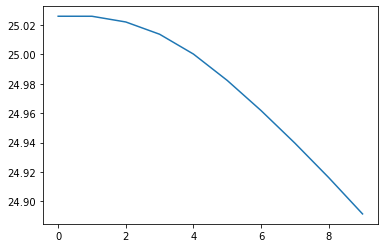

In [106]:
new_T=np.empty((n_nodes, 0)).tolist()
time=1000
for i in range(time):
    storage.Energy_balance(dt=dt,T_inf=T_inf)
    if i%1==0:
        for j in range(n_nodes):
            new_T[j].append(storage.nodes_Temperature[j])

plt.plot(storage.nodes_Temperature)

In [107]:
output_notebook()
colors = itertools.cycle(palette)    
graph = figure(title='IAM vs Incidence angle',plot_width=700, plot_height=500,     # Creates the base figure
                   tools='pan,box_zoom,hover,reset,wheel_zoom,save') #

for i, color in zip(range(n_nodes), colors):
    y = new_T[i]
    x=np.arange(time)
    graph.line(x, y, legend_label=f"node {i}", color=color,line_width=2)
show(graph)

Loading BokehJS ...

In [465]:

class Storage:
    
    def __init__(self,Storage_param):
        
        '''
        Storage's constructor function
        '''
        self.n_nodes=Storage_param['n_nodes']
        self.T_max=Storage_param['T_max']
        self.T_min=Storage_param['T_min']
        
        self.nodes_Temperature=np.linspace(self.T_max,self.T_min,self.n_nodes)
        
        self.h_nodes=Storage_param['H']/self.n_nodes
        self.P=Storage_param['P']*100000
        self.D=D
        self.H=H
        self.A_circ=np.pi*(self.D/2)**2
        self.A_cil_ext=np.pi*self.D*self.h_nodes
        
        self.k_storage=Storage_param['k_storage']
        self.e_storage=Storage_param['e_storage']
        self.k_insulation=Storage_param['k_insulation']
        self.e_insulation=Storage_param['e_insulation']
        
        self.nodes_height=np.linspace(0,self.H,self.n_nodes+1)
        
        #self.h_in=Storage_param['h_in']
        self.h_out=Storage_param['h_out']

        #self.M_in,self.M_out=self.M_vector()
        
        
    def M_vector(self,T_in):
        m_in=np.zeros([self.n_nodes,len(T_in)])
        m_out=np.zeros([self.n_nodes,len(self.h_out)])
        
        for i in range(len(T_in)):
            for j in range(self.n_nodes-1):
                if self.nodes_Temperature[j]>=T_in[i]>self.nodes_Temperature[j+1]:
                    m_in[j][i]=1
                elif self.nodes_Temperature[0]<T_in[i]:
                    m_in[0][i]=1
                elif self.nodes_Temperature[-1]>=T_in[i]:
                    m_in[-1][i]=1
                    
        
        for i in range(len(self.h_out)):
            for j in range(self.n_nodes):
                if self.nodes_height[j]<=self.h_out[i]<self.nodes_height[j+1]:
                    m_out[j][i]=-1
        
        #return m_in,m_out
        self.M_in,self.M_out=m_in,np.flip(m_out)
        #return np.flip(m_in,0),np.flip(m_out,0)
        
    def R_k_cil_external(self,k,D_ext,D_int):
        
        '''
        Method that calculates the conductive thermal resistance of a cylindrical shell
        
        Parameters:
        ----------- 
            -k    : Thermal conductivity of the cylindrical shell material, W/(m*K)
            -D_ext: External diameter of the cylindrical shell, m
            -D_int: Internal diameter of the cylindrical shell, m
            
        Outputs:
        -----------
            -R_k : Conductive thermal resistance ot the cylindrical shell, K/W
            
        '''
        L=self.h_nodes # Height of the cylindrical shell, m
        
        R_k=np.log(D_ext/D_int)/(2*np.pi*L*k) #Conductive thermal resistance ot the cylindrical shell, K/W
        return R_k
    
    def UA_top_bottom(self,T_inf,T_f):
        
        '''
        Function that calculates the 
        '''
        g=9.8
        L=self.h_nodes
        D=self.D
        
        T_s=(T_f+T_inf)/2
        
        it=0
        while True:    
            
            T_p=(T_inf+T_s)/2
            nu_air_ext=CP.PropsSI('V','P',self.P,'T',T_p+273,'air')/CP.PropsSI('D','P',self.P,'T',T_p+273,'air') 
            B_air_ext=1/(T_p+273) 
            Gr=g*B_air_ext*np.abs(T_s-T_inf)*(L**3)/(nu_air_ext**2)
            Pr_air_ext=CP.PropsSI('PRANDTL','P',self.P,'T',T_p+273,'air')
            Ra=Gr*Pr_air_ext

            if 0<Ra<10**9:#10**4<Ra<10**9:
                h=1.32*(np.abs(T_s-T_inf)/D)**0.25
            elif Ra>=10**9:
                h=1.43*np.abs(T_s-T_inf)**(1/3)
            else:
                h=0.001
                
            if self.k_storage!=0: 
                R_k_storage=self.e_storage/(self.k_storage*self.A_circ)
            else:
                R_k_storage=0
            
            if self.k_insulation!=0: 
                R_k_insulation=self.e_insulation/(self.k_insulation*self.A_circ)    
            else:
                R_k_insulation=0
                
            U_h_ext=(1/(h*self.A_cil_ext)+R_k_storage+R_k_insulation)**(-1)
                  
            Q_f_inf=(T_f-T_inf)*U_h_ext
            Q_s_inf=(T_s-T_inf)*self.A_circ*h
            
            err=np.abs(Q_f_inf-Q_s_inf)/Q_s_inf*100
            
            if err<=0.1 or it>=200:
                break
            
            else:
                T_s=T_inf+Q_f_inf/(self.A_circ*h)
                it+=1
                
        return U_h_ext
        
        
        
    def UA_external_surface(self,T_inf,T_f,g=9.8):
        
        g=9.8
        L=self.h_nodes
        D=self.D
        
        T_s=(T_f+T_inf)/2
        
        it=0

        while True:    
            
            T_p=(T_inf+T_s)/2
            nu_air_ext=CP.PropsSI('V','P',self.P,'T',T_p+273,'air')/CP.PropsSI('D','P',self.P,'T',T_p+273,'air')
            B_air_ext=1/(T_p+273)   
            Gr=g*B_air_ext*np.abs(T_s-T_inf)*(L**3)/(nu_air_ext**2)
            Pr_air_ext=CP.PropsSI('PRANDTL','P',self.P,'T',T_p+273,'air')
            Ra=Gr*Pr_air_ext

            if 10**4<Ra<10**9:#10**4<Ra<10**9:
                h=1.42*(np.abs(T_s-T_inf)/L)**0.25
            elif Ra>=10**9:
                h=0.95*np.abs(T_s-T_inf)**(1/3)
            else:
                h=0.001
               
            if self.k_storage!=0: 
                R_k_storage=self.R_k_cil_external(self.k_storage,D_ext=D,D_int=D-self.e_storage)    
            else:
                R_k_storage=0
            
            if self.k_insulation!=0: 
                R_k_insulation=self.R_k_cil_external(self.k_insulation,D_ext=D+self.e_insulation,D_int=D)    
            else:
                R_k_insulation=0
                    
            U_h_ext=(1/(h*self.A_cil_ext)+R_k_storage+R_k_insulation)**(-1)
            
            Q_f_inf=(T_f-T_inf)*U_h_ext
            Q_s_inf=(T_s-T_inf)*self.A_cil_ext*h
            
            err=np.abs((Q_f_inf-Q_s_inf)/Q_s_inf*100)
            if err<=0.1 or it>=200:
                break
            
            else:
                T_s=T_inf+Q_f_inf/(self.A_cil_ext*h)
                it+=1
                
        return U_h_ext
    
    def Conduction(self,T_hot,T_cold):
        
        k_nodes=CP.PropsSI('L','P',self.P,'T',np.linspace(273+np.max(self.nodes_Temperature),273+np.min(self.nodes_Temperature),n_nodes),'water')
        k_nodes=np.mean(k_nodes)
        
        Q_cond=k_nodes*self.A_circ*(T_hot-T_cold)/self.h_nodes
        
        return Q_cond
    
    def Mass_balance(self,m_in,m_out):
        
        M_in=np.sum(m_out)-np.sum(m_in)
        m_in=np.insert(m_in,len(m_in),M_in)
        return(m_in)
            
    def Energy_balance(self,dt,T_inf,m_in=None,T_in=None,m_out=None):
        '''
        Function that calculates and updates the temperature of each node by doing an energy balance.
        
        Parameters:
        -----------
        dt   : Time step of the simulation, s.
        T_inf: Ambient temperature, °C
        
        Outputs:
        ---------
        nodes.Temperature: Numpy array of shape (n_nodes,) that contains the resulting temperature of each node
        
        '''  
        self.M_vector(T_in=T_in)
        m_in=self.Mass_balance(m_in,m_out)
        #H_in=CP.PropsSI('H','P',self.P,'T',273+T_in,'water')
        #q_in=m_in*H_in
        cp_in=CP.PropsSI('C','P',self.P,'T',273+T_in,'water')
        q_in=m_in*np.array(T_in)*cp_in
        Q_in=np.matmul(self.M_in,q_in)
        #print(Q_in)
        M_in_vector=np.matmul(self.M_in,m_in)
        
        T_out=np.zeros(len(self.h_out))
        for i in range(len(self.h_out)):
            for j in range(self.n_nodes):
                if self.nodes_height[j]<=self.h_out[i]<self.nodes_height[j+1]:
                    T_out[i]=self.nodes_Temperature[j]


    
        #H_out=CP.PropsSI('H','P',self.P,'T',273+T_out,'water')   
        #q_out=m_out*H_out
        cp_out=CP.PropsSI('C','P',self.P,'T',273+T_out,'water')
        q_out=m_in*np.array(T_out)*cp_out
        Q_out=np.matmul(self.M_out,q_out)
        #print(Q_out)
        
        cp_nodes=CP.PropsSI('C','P',self.P,'T',                               # Array that contains 
                            np.linspace(273+np.max(self.nodes_Temperature),   # the value of Cp on
                            273+np.min(self.nodes_Temperature),n_nodes),      # each node
                            'water')                                          #
        cp_nodes=np.mean(cp_nodes) # Mean value of Cp, J/(kg*K)
        
        rho_nodes=CP.PropsSI('D','P',self.P,'T',                              # Array that contains
                             np.linspace(273+np.max(self.nodes_Temperature),  # the value of density 
                             273+np.min(self.nodes_Temperature),n_nodes),     # on each node
                             'water')                                         #
        rho_nodes=np.mean(rho_nodes) # Mean value of density, kg/m^{3}
        
        V=self.A_circ*self.h_nodes  #Volume of each node, m^{3}
         
        new_nodes_Temperature=np.zeros(n_nodes) #Empty array to fulfill with the new temperature of the nodes 
        
        for i in range(self.n_nodes): # Loop to go through all the nodes
            
            if i>=1 and i<n_nodes-1:  #Energy balance for the middle nodes
                
                Q_cond=(self.Conduction(self.nodes_Temperature[i-1],self.nodes_Temperature[i])   # Heat transferred to the current node from
                                                                                                 # the node located above it
                        
                        -self.Conduction(self.nodes_Temperature[i],self.nodes_Temperature[i+1])) # Heat transferred from the current node 
                                                                                                 # to the node located below it
                    
                Q_loss_external_surface=(-self.UA_external_surface(T_inf,self.nodes_Temperature[i]) # Heat transferred from the storage´s inside
                                         *(self.nodes_Temperature[i]-T_inf))                        # to the environment

                Q_m_in=Q_in[i]
                Q_m_out=Q_out[i]
                #new_nodes_Temperature[i]=self.nodes_Temperature[i]+(Q_cond+Q_loss_external_surface)*dt/(V*rho_nodes*cp_nodes)
                new_nodes_Temperature[i]=self.nodes_Temperature[i]+(Q_cond+Q_loss_external_surface+Q_m_in+Q_m_out)*dt/((V*rho_nodes)*cp_nodes) # New temperature of the node i
                 
            elif i==0: #Energy balance for the node at the top of the storage     
                
                Q_cond=-self.Conduction(self.nodes_Temperature[i],self.nodes_Temperature[i+1]) # Heat transferred from the current node
                                                                                               # to the node located below it
                    
                Q_loss_external_surface=(-self.UA_external_surface(T_inf,self.nodes_Temperature[i]) # Heat transferred from the storage´s inside
                                         *(self.nodes_Temperature[i]-T_inf))                        # to the environment by the cylindrical surface
                
                Q_loss_top=(-self.UA_top_bottom(T_inf,self.nodes_Temperature[i]) # Heat transferred from the storage´s inside
                            *(self.nodes_Temperature[i]-T_inf))                  # to the environment by the top surface
                
                Q_m_in=Q_in[i]
                Q_m_out=Q_out[i]
                new_nodes_Temperature[i]=self.nodes_Temperature[i]+(Q_cond+Q_loss_external_surface+Q_loss_top+Q_m_in+Q_m_out)*dt/((V*rho_nodes)*cp_nodes) # New temperature of the node i
                
            else: #Energy balance for the node at the bottom of the storage     
                
                Q_cond=self.Conduction(self.nodes_Temperature[i-1],self.nodes_Temperature[i]) # Heat transferred to the current node from
                                                                                              # the node located above it
                
                Q_loss=(-self.UA_external_surface(T_inf,self.nodes_Temperature[i]) # Heat transferred from the storage´s inside
                        *(self.nodes_Temperature[i]-T_inf))                        # to the environment by the cylindrical surface
                                                                                                                    
                Q_loss_bottom=(self.UA_top_bottom(T_inf,self.nodes_Temperature[i]) # Heat transferred between the node at the bottom 
                               *(self.nodes_Temperature[i]-T_inf))                 # of the storage and the enviroment
                
                Q_m_in=Q_in[i]
                Q_m_out=Q_out[i]
                new_nodes_Temperature[i]=self.nodes_Temperature[i]+(Q_cond+Q_loss_external_surface+Q_loss_bottom+Q_m_in+Q_m_out)*dt/((V*rho_nodes)*cp_nodes) # New temperature of the node i
                
        self.nodes_Temperature=new_nodes_Temperature # Update of the nodes temperature
        #self.nodes_Temperature=np.sort(new_nodes_Temperature)[::-1]
        return self.nodes_Temperature

In [472]:
T_max=90
T_min=10
n_nodes=10
P=1
D=1
H=2
dt=3600
e_storage=0.002
k_storage=80
e_insulation=0.011
k_insulation=0.1

h_out=[1.9,1.9]

storage_param={'T_max':T_max,
               'T_min':T_min,
               'n_nodes':n_nodes,
               'P':P,
               'D':D,
               'H':H,
               'dt':dt,
               'e_storage':e_storage,
               'k_storage':k_storage,
               'e_insulation':e_insulation,
               'k_insulation':k_insulation,
               'h_out':h_out}


storage=Storage(storage_param)
#plt.plot(storage.nodes_Temperature)

In [473]:
#T_in=np.array([10,90])
#m_in=np.array([0.01])
#m_out=[0.01,0.01]
T_inf=25
T_in=np.array([70,40])
m_in=np.array([0.01])
m_out=[0.01,0.01]

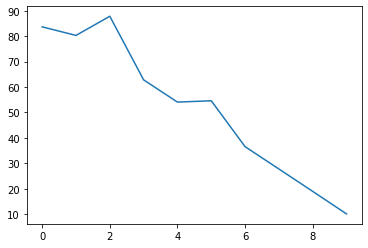

In [474]:
storage.Energy_balance(dt=dt,T_inf=T_inf,T_in=T_in,m_in=m_in,m_out=m_out)
plt.plot(storage.nodes_Temperature)

In [475]:
storage.M_out

array([[-1., -1.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

In [476]:
storage.M_in

array([[0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 0.],
       [0., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [477]:
new_T=np.empty((n_nodes, 0)).tolist()
time=500
for i in range(time):
    for j in range(n_nodes):
        new_T[j].append(storage.nodes_Temperature[j])
    storage.Energy_balance(dt=dt,T_inf=T_inf,T_in=T_in,m_in=m_in,m_out=m_out)
    #print(i)
plt.plot(storage.nodes_Temperature)

ValueError: No outputs were able to be calculated

In [450]:
output_notebook()
colors = itertools.cycle(palette)    
graph = figure(title='IAM vs Incidence angle',plot_width=700, plot_height=500,     # Creates the base figure
                   tools='pan,box_zoom,hover,reset,wheel_zoom,save') #

for i, color in zip(range(n_nodes), colors):
    y = new_T[i]
    x=np.arange(time)
    graph.line(x, y, legend_label=f"node {i}", color=color,line_width=2)
show(graph)

Loading BokehJS ...

In [220]:
a=np.sort(storage.nodes_Temperature)

In [222]:
np.sort(a)[::-1]

array([84.09889007, 60.57267867, 46.89227227, 38.75680891, 33.81283678,
       30.74275053, 28.7914347 , 27.51561386, 26.64721733, 26.01770433,
       25.51508542, 25.05951056, 24.58909655, 24.05904611, 23.39069461,
       22.46986837, 21.12187468, 19.06641436, 15.83763595, 10.63933716])

In [483]:
nodes_sorted=np.sort(storage.nodes_Temperature)[::-1]

In [491]:
nodes_sorted==storage.nodes_Temperature

array([False, False, False,  True, False, False, False, False, False,
        True])

In [485]:
storage.nodes_Temperature

array([167.08237434,  71.53964682, 128.35264215, 180.75685628,
        79.69513107, 108.80285355, 230.68701308, 484.64244569,
       346.28945048,  -5.76417376])

In [486]:
nodes_sorted

array([484.64244569, 346.28945048, 230.68701308, 180.75685628,
       167.08237434, 128.35264215, 108.80285355,  79.69513107,
        71.53964682,  -5.76417376])

In [490]:
if (nodes_sorted==storage.nodes_Temperature).any():
    print(1)

1


In [497]:
n=0
for i in nodes_sorted==storage.nodes_Temperature:
    if not i:
        print(i)
    
    print(n)
    n+=1

False
0
False
1
False
2
3
False
4
False
5
False
6
False
7
False
8
9
